In [ ]:
install.packages("quantmod")
install.packages("data.table")
install.packages("fGarch")
install.packages("rugarch")

In [50]:
library(quantmod)
library(data.table)
library(fGarch)
library(rugarch)

In [9]:
getSymbols("^GSPC", src="yahoo", form="2015-01-01", to = "2020-06-04")

[1] "^GSPC"

In [15]:
z = as.data.table(GSPC)
z1 = z[, c("index", "GSPC.Close")]
z1 = z1[, r:=c(0, diff(log(GSPC.Close)))][-1,]
z1 = z1[, r_square:=r^2]
        

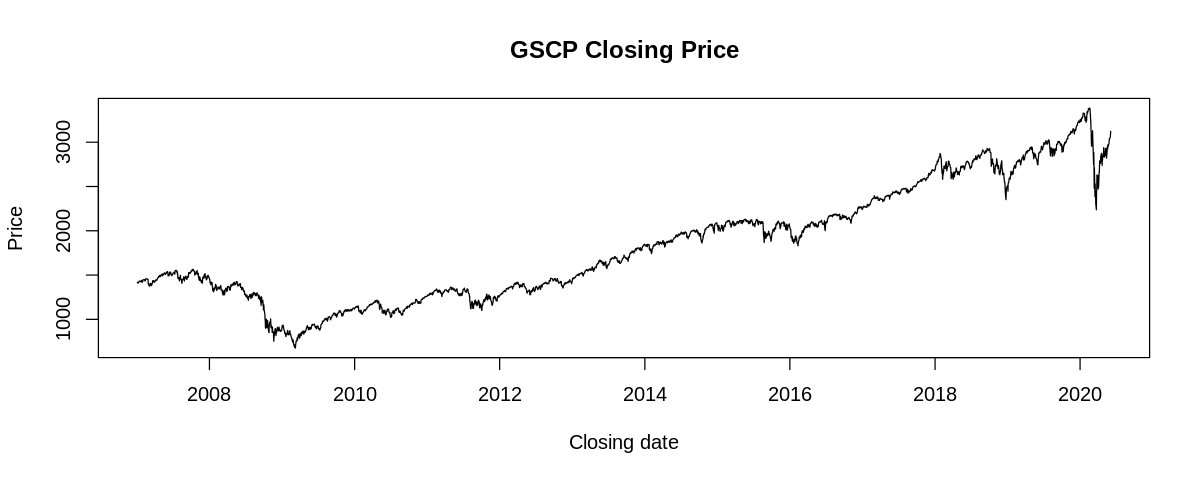

In [21]:
options(repr.plot.width=10)
options(repr.plot.height=4)
plot(z$index, z$GSPC.Close, xlab = "Closing date", ylab='Price', main = "GSCP Closing Price", type = 'l')

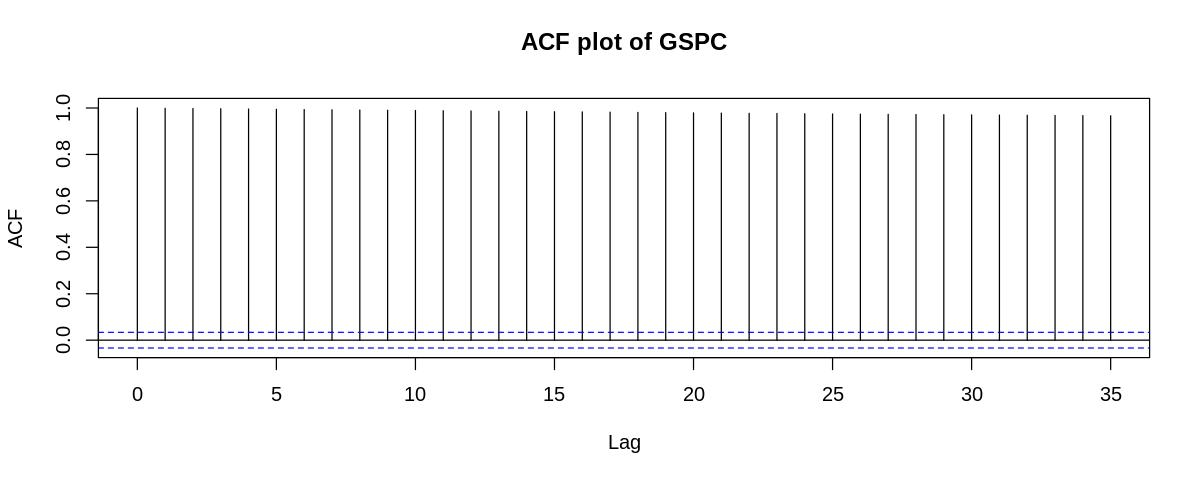

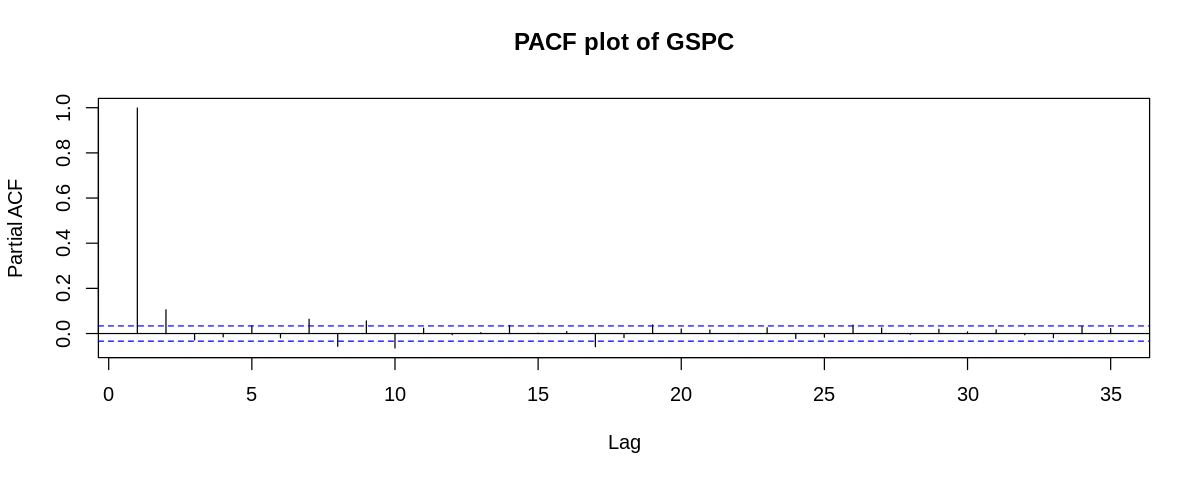

In [25]:
zr1 = acf(z$GSPC.Close, plot = FALSE)
zr2 = pacf(z$GSPC.Close, plot = FALSE)
plot(zr1, main = "ACF plot of GSPC")
plot(zr2, main = "PACF plot of GSPC")


## GSPC log return

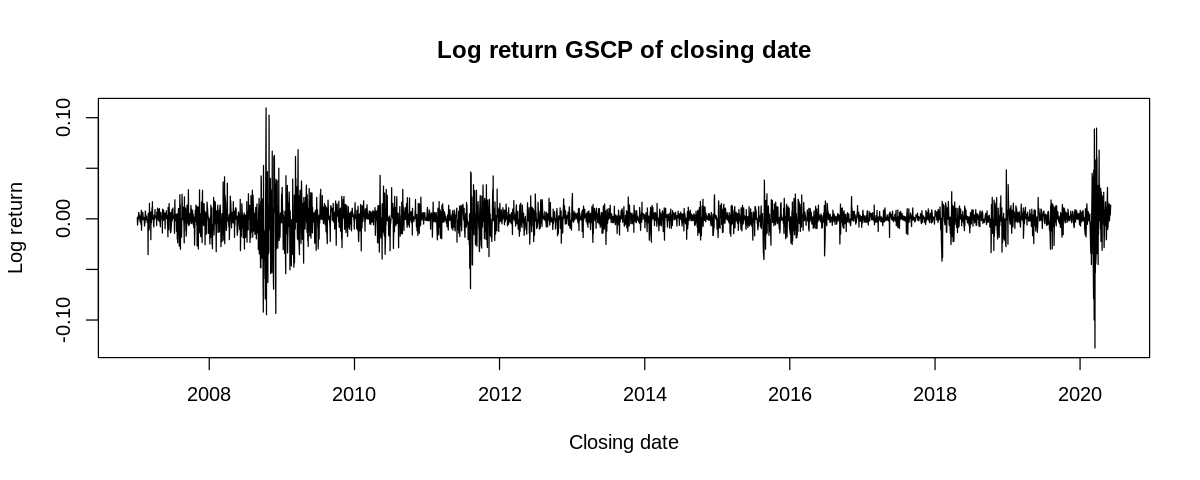

In [26]:
plot(z1$index, z1$r, xlab = "Closing date", ylab = "Log return", main = "Log return GSCP of closing date", type = "l")

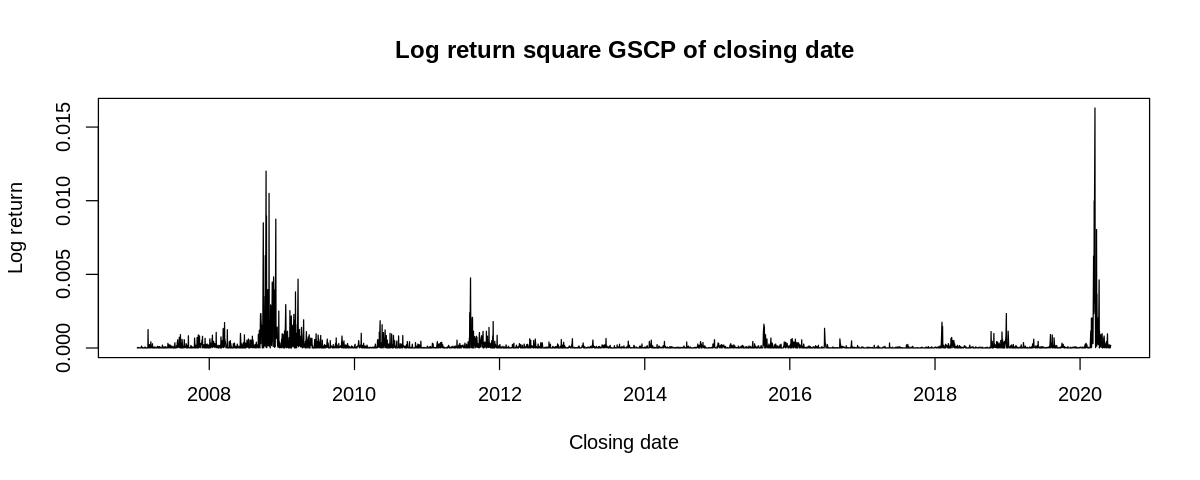

In [28]:
plot(z1$index, z1$r_square, xlab = "Closing date", ylab = "Log return", main = "Log return square GSCP of closing date", type = "l")

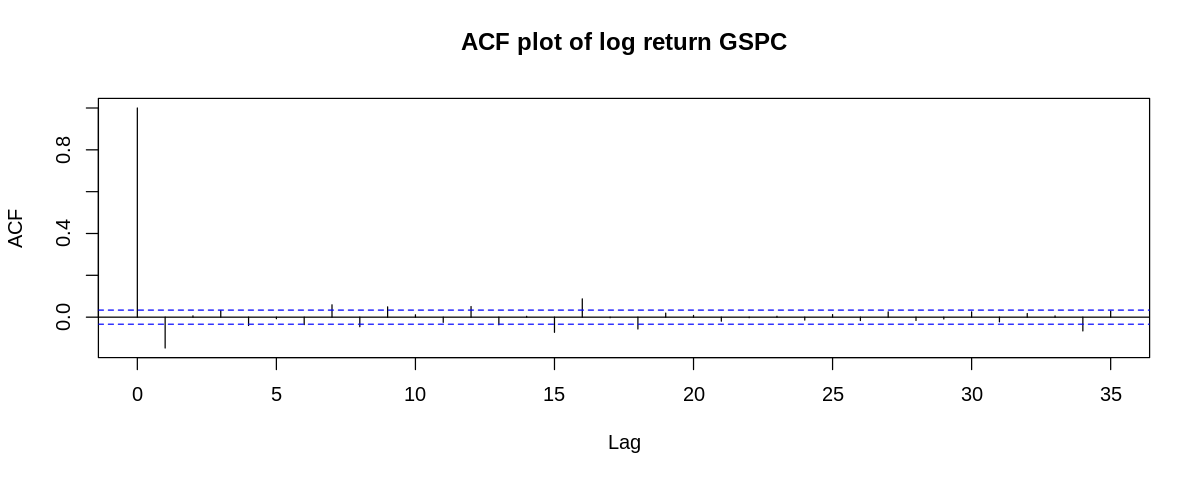

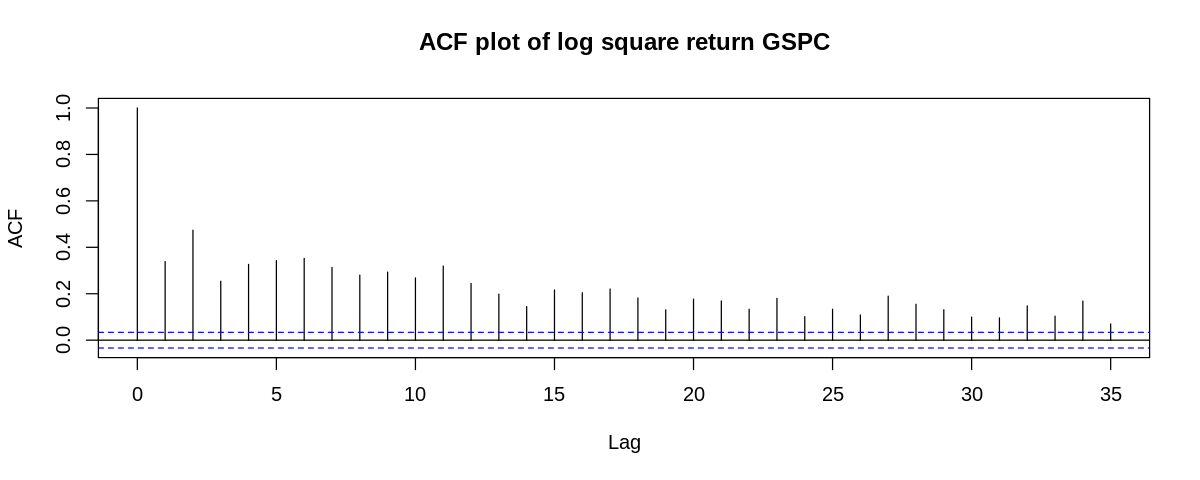

In [36]:
zrl1 = acf(z1$r, plot = FALSE)
zrl2 = acf(z1$r_square, plot = FALSE)
plot(zrl1, main = "ACF plot of log return GSPC")
plot(zrl2, main = "ACF plot of log square return GSPC")

In [35]:
Box.test(z1$r^2, lag = 1, type = "Ljung-Box")
Box.test(z1$r^2, lag = 2, type = "Ljung-Box")
Box.test(z1$r^2, lag = 4, type = "Ljung-Box")
Box.test(z1$r^2, lag = 6, type = "Ljung-Box")


	Box-Ljung test

data:  z1$r^2
X-squared = 387.3, df = 1, p-value < 2.2e-16



	Box-Ljung test

data:  z1$r^2
X-squared = 1146, df = 2, p-value < 2.2e-16



	Box-Ljung test

data:  z1$r^2
X-squared = 1724.3, df = 4, p-value < 2.2e-16



	Box-Ljung test

data:  z1$r^2
X-squared = 2541.4, df = 6, p-value < 2.2e-16


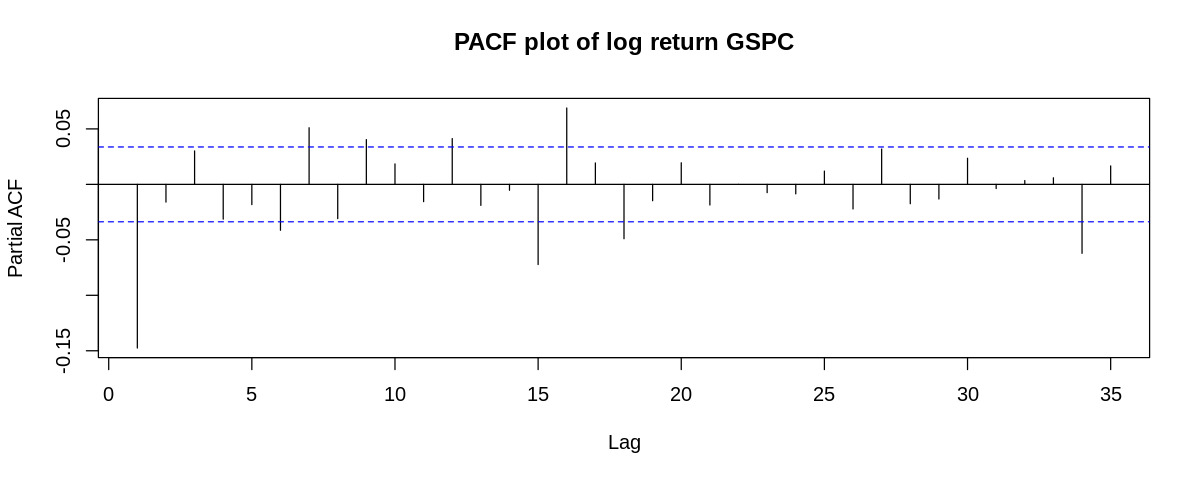

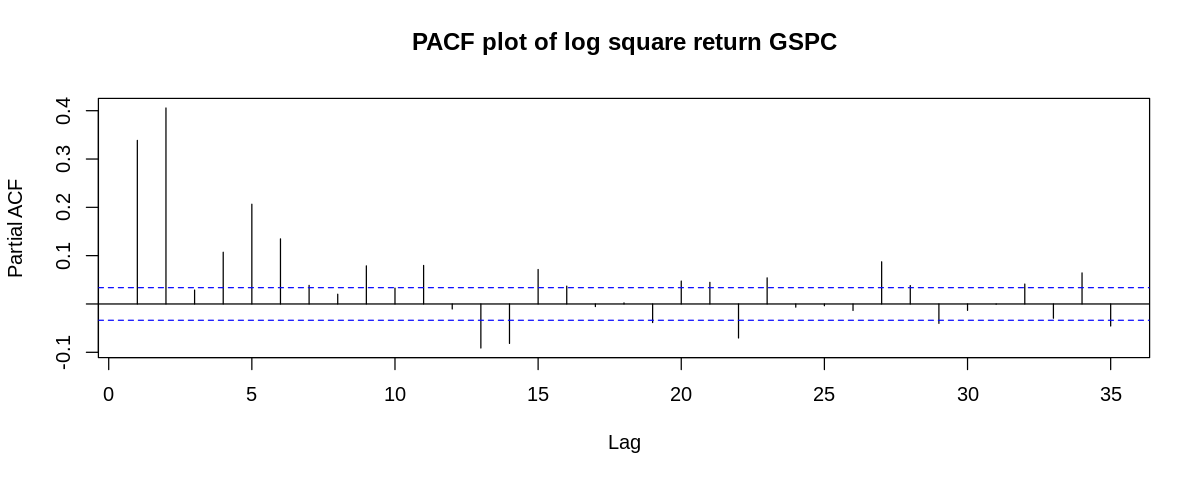

In [37]:
zrl1 = pacf(z1$r, plot = FALSE)
zrl2 = pacf(z1$r_square, plot = FALSE)
plot(zrl1, main = "PACF plot of log return GSPC")
plot(zrl2, main = "PACF plot of log square return GSPC")

In [42]:
#r.g <- garchFit(arma(0,0)+garch(1,0), data = z1$r, cond.dist="norm")
r.g <- garchFit(~arma(1,0)+garch(1,1), data = z1$r, cond.dist="std")
summary(r.g)


Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(1, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(1, 1)
 ARMA Order:                1 0
 Max ARMA Order:            1
 GARCH Order:               1 1
 Max GARCH Order:           1
 Maximum Order:             1
 Conditional Dist:          std
 h.start:                   2
 llh.start:                 1
 Length of Series:          3377
 Recursion Init:            mci
 Series Scale:              0.01318334

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U           V      params includes
    mu     -0.17755848   0.1775585  0.01770095     TRUE
    ar1    -0.99999999   1.0000000 -0.14749037     TRUE
    omega   0.00000100 100.0000000  0.10000000     TRUE
    alpha1  0.00000001   1.0000000  0.10000000     TRUE
    gamma1 -0.99999999   1.0000000 

In [44]:
print(coef(r.g))

           mu           ar1         omega        alpha1         beta1 
 9.457936e-04 -7.150415e-02  1.730486e-06  1.595360e-01  8.460841e-01 
        shape 
 4.794298e+00 


## Q-Q plot of the best model

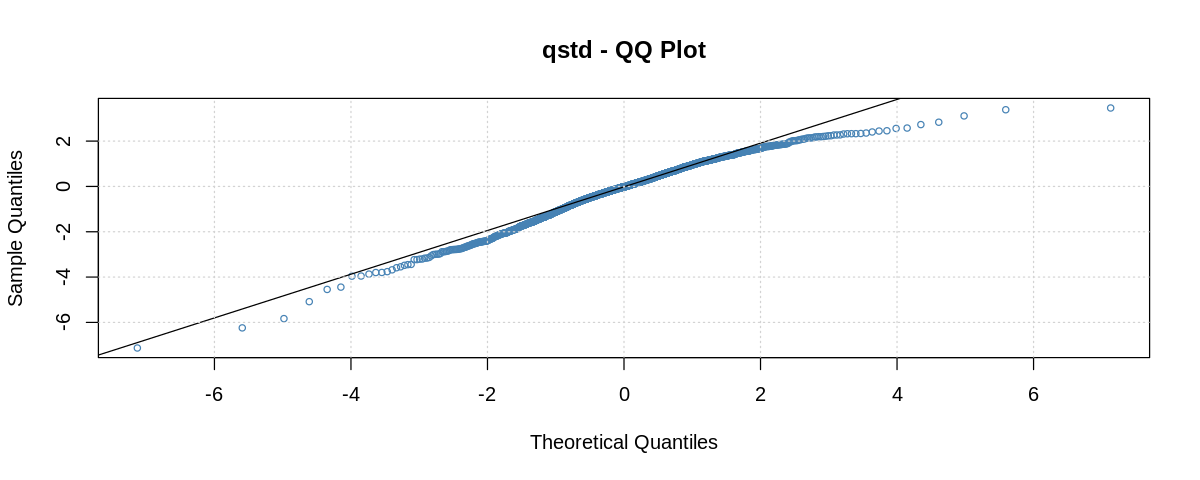

In [45]:
plot(r.g, which = 13)

## Volatility estimate of the best model

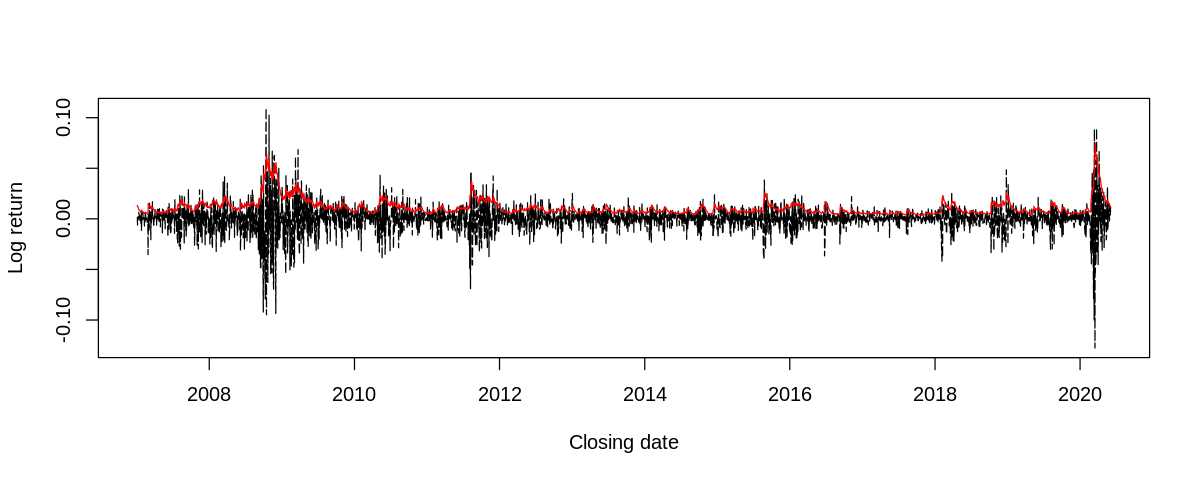

In [47]:
plot(z1$index, z1$r, type = 'l', xlab = "Closing date", ylab='Log return', lty = 5)
lines(z1$index, r.g@sigma.t, col = 'red')

## Forecast using rugarch lib

Ref: https://palomar.home.ece.ust.hk/MAFS6010R_lectures/Rsession_time_series_modeling.html#arch_and_garch_models

In [67]:
out_of_sample <- round(length(z1$r)/2)

In [68]:
dates_out_of_sample <- tail(index(z1), out_of_sample)

In [69]:
garch_spec <- ugarchspec(mean.model = list(armaOrder = c(1,0), include.mean = TRUE), 
                         variance.model = list(model = "sGARCH", garchOrder = c(1,1)), distribution.model = "std")

garch_fit <- ugarchfit(spec = garch_spec, data = xts(z1$r, order.by=z1$index), out.sample = out_of_sample)
print(coef(garch_fit))

           mu           ar1         omega        alpha1         beta1 
 1.000476e-03 -7.082892e-02  2.082914e-06  1.164922e-01  8.825071e-01 
        shape 
 5.028100e+00 


### Volatility Forecast

In [91]:
garch_fore <- ugarchforecast(garch_fit, n.ahead = 1, n.roll = out_of_sample-1)
forecast_log_returns <- xts(garch_fore@forecast$seriesFor[1, ], z1$index[dates_out_of_sample])
forecast_volatility <- xts(garch_fore@forecast$sigmaFor[1, ], z1$index[dates_out_of_sample])

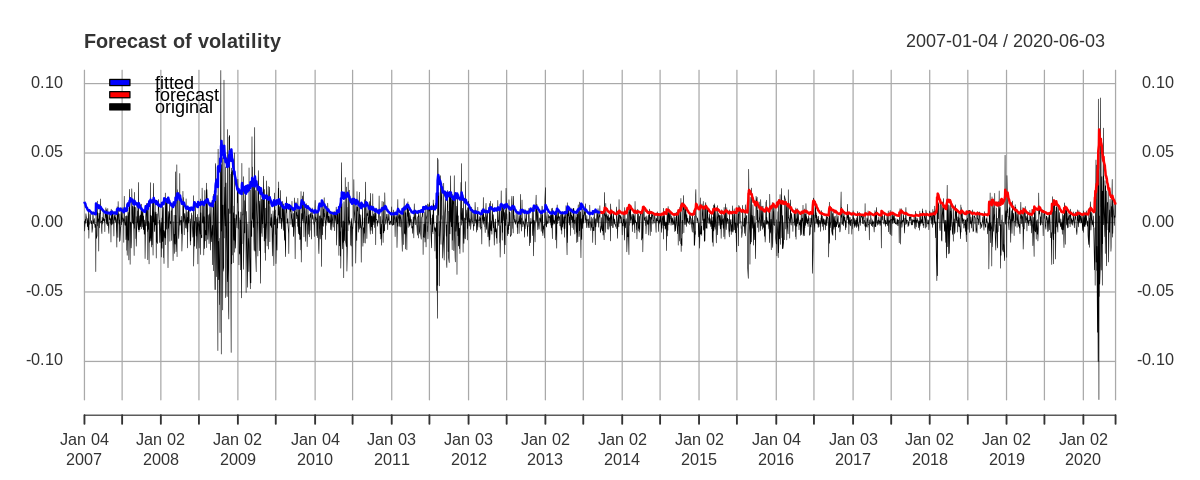

In [92]:
par(cex = 0.5)
plot(cbind("fitted"   = sigma(garch_fit),
           "forecast" = forecast_volatility,
           "original" = z1$r), 
     col = c("blue", "red", "black"), lwd = c(2, 2, 0.5),
     main = "Forecast of volatility", legend.loc = "topleft")

## Log-return Forecase

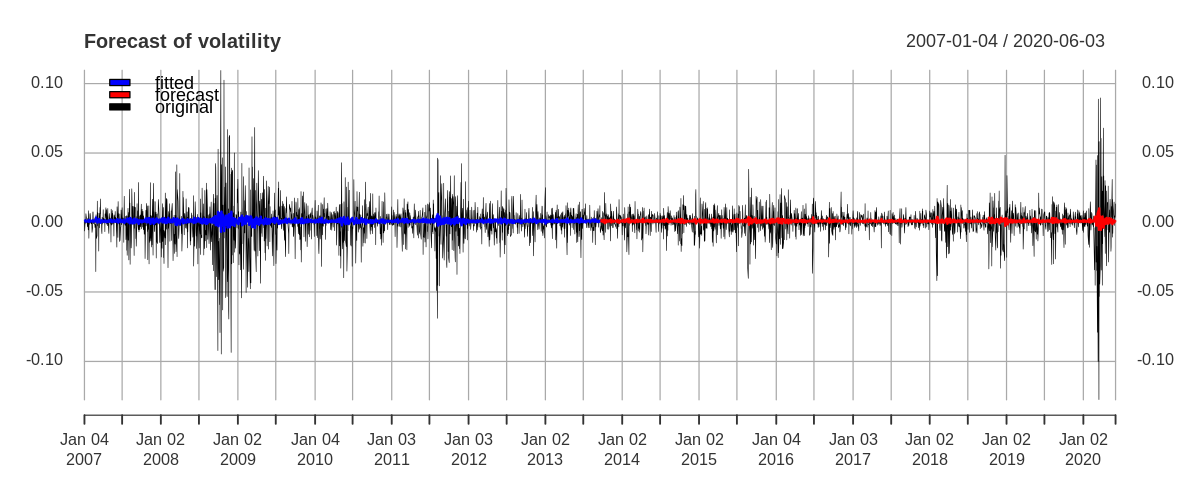

In [93]:
par(cex = 0.5)
plot(cbind("fitted"   = fitted(garch_fit),
           "forecast" = forecast_log_returns,
           "original" = z1$r), 
     col = c("blue", "red", "black"), lwd = c(2, 2, 0.5),
     main = "Forecast of volatility", legend.loc = "topleft")

## Conclusion

Garch models are only good for forecasting the volatility. They are not good for log returen forecast.